## Training a Neural Network with PyTorch

Now it's time to train a neural network using data.

Usually when we have real world (or toy) data, we have to use packages which load data and convert them into tensor generators. In PyTorch there are `datasets` and `Dataloaders`.

* **datasets** define batches of input tensors and their targets
* **Dataloaders** generate datasets

For most real world datasets, care has to be taken to specify efficient datasets and dataloaders of trainable tensors. However for images, there is a specific package called `torchvision` which makes things conveniently easier.

In this tutorial we will use the **CIFAR10** dataset which has 10 classes:

> airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Images in CIFAR10 are of size `3x32x32` corresponding to **3 RGB colour channels** and **32x32 pixels**.

### Training a CIFAR10 Classifier

To train a **CIFAR10 Classifier** we will take the following steps

1. Load and normalise CIFAR10 training and test sets
2. Define a convolutional neural network
3. Define a loss function and optimiser
4. Train the neural network on the training dataset
5. Test the neural network on the test dataset

In [35]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

HOME = os.environ["AI_HOME"]
ROOT = os.path.join(HOME, "artificial_neural_networks")
DATA = os.path.join(ROOT, "data")
CIFAR10 = os.path.join(DATA, "cifar10")

## 1. Dataloaders

Torchvision contains a special dataloader for CIFAR10. Now the output of this dataset is a `PILImage` of range `[0,1]` which will need to transform and normalise to a tensor of range `[-1,1]`. To do so we will use the following set of compositional transforms:

In [3]:
transform = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            )

Now we will define the training and test datasets as well as independent dataloaders for them

In [7]:
trainset = torchvision.datasets.CIFAR10(root=CIFAR10, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified


In [8]:
testset = torchvision.datasets.CIFAR10(root=CIFAR10, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Visualising the Data

In [12]:
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

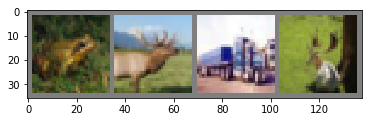

 frog  deer truck  deer


In [27]:
# get some random training images
data_iter = iter(trainloader)
images, labels = data_iter.next()  # recall that batch_size=4

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a CNN Classifier

We will use the CNN classifier from the previous tutorial, only modified to take in 3-channel RGB images.

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [49]:
net = CNN()

## 3. Define a Loss Function and Optimiser

In [50]:
cross_entropy = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the Network

We will train over several epochs (one epoch is one complete pass over the dataset)

In [51]:
for epoch in range(5):
    print(f"Epoch: {epoch + 1} " + "="*80 + ">")
    total_loss = 0.0
    for idx, sample in enumerate(trainloader, 0):
        inputs, labels = sample
        
        # zero parameter gradients
        optimiser.zero_grad()
        
        # forward pass
        outputs = net(inputs)
        loss = cross_entropy(outputs, labels)
        # backward pass
        loss.backward()
        # optimise
        optimiser.step()
        
        # print training progress and statistics
        total_loss += loss.item()  # loss is a scalar so extract using `.item`
        if idx % 2000 == 1999:  # print every 2000 minibatches
            print('[%5d/12000] loss: %.3f' % (idx + 1, total_loss / 2000))
            total_loss = 0.0

print("Finished training." + "="*70 + ">")        

Epoch: 1 ================================================================================>
[ 2000/12000] loss: 2.245
[ 4000/12000] loss: 1.913
[ 6000/12000] loss: 1.704
[ 8000/12000] loss: 1.613
[10000/12000] loss: 1.533
[12000/12000] loss: 1.491
Epoch: 2 ================================================================================>
[ 2000/12000] loss: 1.437
[ 4000/12000] loss: 1.413
[ 6000/12000] loss: 1.368
[ 8000/12000] loss: 1.355
[10000/12000] loss: 1.350
[12000/12000] loss: 1.335
Epoch: 3 ================================================================================>
[ 2000/12000] loss: 1.271
[ 4000/12000] loss: 1.265
[ 6000/12000] loss: 1.268
[ 8000/12000] loss: 1.229
[10000/12000] loss: 1.231
[12000/12000] loss: 1.214
Epoch: 4 ================================================================================>
[ 2000/12000] loss: 1.160
[ 4000/12000] loss: 1.162
[ 6000/12000] loss: 1.143
[ 8000/12000] loss: 1.156
[10000/12000] loss: 1.132
[12000/12000] loss: 1.139
Epoch: 5 ===

## 5. Test the Network

Now that we have a trained model we can test it. First we use the image plotting function to visually check the ground truth:

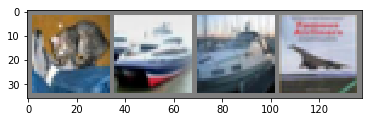

GroundTruth:    cat  ship  ship plane


In [52]:
test_iter = iter(testloader)
images, labels = test_iter.next()

# print images
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Then using the same set of images, let's see what the trained neural network predicts:

In [53]:
outputs = net(images)
# use argmax to get predicted class indices
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


Now we see how the neural network performs overall on the whole test dataset

In [56]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


### Analyse Class Performance

We can try and check which classes the neural network did well on and which it do not perform well.

In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 72 %
Accuracy of  bird : 46 %
Accuracy of   cat : 31 %
Accuracy of  deer : 49 %
Accuracy of   dog : 43 %
Accuracy of  frog : 79 %
Accuracy of horse : 71 %
Accuracy of  ship : 83 %
Accuracy of truck : 69 %
